# Adversarial Example Generation for Images

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import pandas as pd
import numpy as np

from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

In [3]:
import torch
import torch.tensor as T
from torch import nn, optim
from torch.nn import functional as F

from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchsummary import summary

from sklearn.metrics import accuracy_score
from skorch import NeuralNetClassifier
from skorch.callbacks import Checkpoint, Freezer, LRScheduler, EarlyStopping, Unfreezer
from skorch.dataset import CVSplit

print(f"GPU present: {torch.cuda.is_available()}")

GPU present: True


/home/sudarshan/miniconda3/envs/adv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
img_size=(150,150)
data_stats = dict(mean=T([0.4302, 0.4575, 0.4539]), std=T([0.2361, 0.2347, 0.2433]))
data_path = Path('./data')

## Functions

In [5]:
def for_disp(img):
  img_disp = img.mul(data_stats['std'][:, None, None]).add(data_stats['mean'][:, None, None])
  return transforms.ToPILImage()(img_disp)

def get_stats(loader):
  mean,std = 0.0,0.0
  nb_samples = 0
  for imgs, _ in loader:
    batch = imgs.size(0)
    imgs = imgs.view(batch, imgs.size(1), -1)
    mean += imgs.mean(2).sum(0)
    std += imgs.std(2).sum(0)
    nb_samples += batch

  return mean/nb_samples, std/nb_samples

## EDA Data

In [ ]:
imgs,labels = [],[]
n_imgs = 5

for folder in (data_path/'train').iterdir():
  label = folder.name  
  for img_f in list(folder.glob('*.jpg'))[:n_imgs]:
    with Image.open(img_f) as f:
      imgs.append(np.array(f))
    labels.append(label)

n_classes = len(np.unique(labels))

In [ ]:
fig = plt.figure(figsize=(15, 15))

for i, img in enumerate(imgs):
  ax = fig.add_subplot(n_classes, n_imgs, i+1)
  ax.imshow(img)
  ax.set_title(labels[i], color='r')
  ax.set_xticks([])
  ax.set_yticks([])
    
plt.show()

In [ ]:
train_tfms = transforms.Compose(
  [
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(**data_stats),    
  ]
)

pred_tfms = transforms.Compose(
  [
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(**data_stats)
  ]
)

In [ ]:
ds = ImageFolder(data_path/'train', transform=train_tfms)

train_pct = 0.85
n_train = np.int(len(ds) * train_pct)
n_val = len(ds) - n_train

train_ds,val_ds = random_split(ds, [n_train, n_val])
train_ds,val_ds = train_ds.dataset,val_ds.dataset

In [ ]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
train_itr = iter(train_dl)

val_dl = DataLoader(val_ds, batch_size=32)
val_itr = iter(val_dl)

test_ds = ImageFolder(data_path/'test', transform=pred_tfms)
test_dl = DataLoader(test_ds, batch_size=32)

In [ ]:
imgs, labels = next(train_itr)

In [ ]:
idx = np.random.randint(len(imgs))

print(train_ds.classes[labels[idx].item()])
img = for_disp(imgs[idx])
img

In [ ]:
clf = IntelImageClassifier().cuda()
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(clf.parameters(), lr=0.01)

In [ ]:
imgs, labels = next(train_itr)
imgs = imgs.cuda()
labels = labels.cuda()

pred = clf(imgs)
loss_fn(pred, labels)

## Build Model

### Setup

In [6]:
tfms = {}    
tfms['train'] = transforms.Compose([
  transforms.Resize((150, 150)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor(),
  transforms.Normalize(**data_stats)
])
tfms['pred'] = transforms.Compose([
  transforms.Resize((150, 150)),
  transforms.ToTensor(),
  transforms.Normalize(**data_stats)
])

train_ds = ImageFolder(data_path/'train', transform=tfms['train'])
test_ds = ImageFolder(data_path/'test', transform=tfms['pred'])

In [7]:
class PretrainedClf(nn.Module):
  def __init__(self, arch):
    super(PretrainedClf, self).__init__()      
    if arch == 'vgg16':
      self.model = models.vgg19_bn(pretrained=True) # load pretrained model    
      # replace last layer with custom layer
      classifier = nn.Sequential(
        nn.Linear(in_features=25088, out_features=4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=4096, out_features=4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=4096, out_features=6) # 6 classes
      )
      self.model.classifier = classifier
    elif arch  == 'resnet34':
      self.model = models.resnet34(pretrained=True)
      self.model.fc = nn.Linear(self.model.fc.in_features, 6)
    elif arch  == 'resnet50':
      self.model = models.resnet50(pretrained=True)
      self.model.fc = nn.Linear(self.model.fc.in_features, 6)      
    else:
      raise ValueError("Arch must be one of vgg16, resnet34 and resnet50")
    
  def forward(self, x):
    return self.model(x)

In [ ]:
# train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, drop_last=True)
# loss_fn = nn.CrossEntropyLoss()
# itr = iter(train_dl)

# summary(model.cuda(), input_size=(3,150,150))

# imgs, labels = itr.next()
# pred = model(imgs)
# loss = loss_fn(pred, labels)
# print(loss)

In [8]:
arch = 'vgg16'
model = PretrainedClf(arch)

if arch == 'vgg16':
  layer_name = 'model.classifier'
elif arch in ['resnet34', 'resnet50']:
  layer_name = 'model.fc'

In [9]:
lrscheduler = LRScheduler(policy='StepLR', step_size=7, gamma=0.1)
chkpt = Checkpoint(dirname=Path(f'./workdir/{arch}'), monitor='valid_acc_best')
freezer = Freezer(lambda x: not x.startswith(layer_name))
unfreezer = Unfreezer(lambda x: not x.startswith(layer_name))

callbacks = [lrscheduler, chkpt, freezer, EarlyStopping()]

In [10]:
net = NeuralNetClassifier(
  model,
  criterion=nn.CrossEntropyLoss,
  lr=0.001,
  batch_size=128,
  max_epochs=25,
  optimizer=optim.Adam,
  iterator_train__shuffle=True,
  iterator_train__drop_last=True,
  iterator_train__num_workers=4,
  iterator_valid__shuffle=False,  
  train_split=CVSplit(cv=0.15),
  callbacks=callbacks,
  device='cuda:0'
)

### Training

In [ ]:
net.fit(train_ds, y=None);

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
n_epochs = len(net.history)
sns.lineplot(range(n_epochs), net.history[:, 'train_loss'])
sns.lineplot(range(n_epochs), net.history[:, 'valid_loss'])
ax.legend(['train_loss', 'valid_loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [ ]:
net.callbacks.remove(freezer)
net.callbacks.append(unfreezer)
net.callbacks

In [ ]:
net.partial_fit(train_ds, y=None);

### Inference

In [11]:
net.initialize();
net.load_params(checkpoint=chkpt)

Text(0, 0.5, 'Loss')

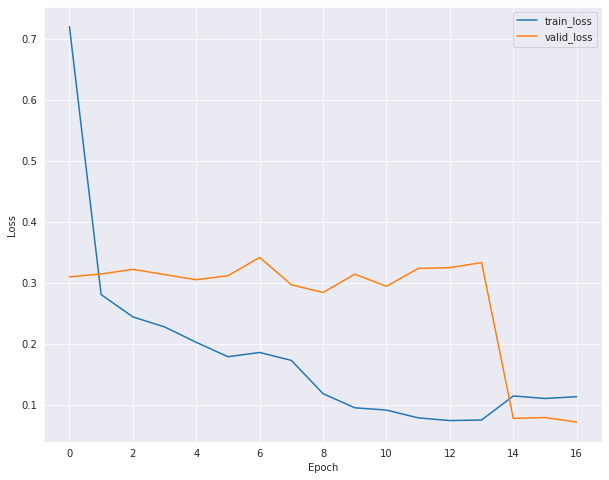

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
n_epochs = len(net.history)
sns.lineplot(range(n_epochs), net.history[:, 'train_loss'])
sns.lineplot(range(n_epochs), net.history[:, 'valid_loss'])
ax.legend(['train_loss', 'valid_loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [17]:
pred = net.predict(test_ds)
test_dl = DataLoader(test_ds, batch_size=len(test_ds))
_, y_true = iter(test_dl).next()
y_true = y_true.numpy()

print(f"Accuracy of labeled test set= {accuracy_score(y_true, pred)*100:0.2f}%")

Accuracy of labeled test set= 91.43%


In [14]:
classes = train_ds.classes

In [15]:
class UnlabeledTestSet(Dataset):
  def __init__(self, data_path, tfms=transforms.ToTensor()):
    self.imgs = list((data_path/'unlabeled_test').glob('*.jpg'))
    self.tfms = tfms
    
  def __len__(self):
    return len(self.imgs)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
      
    with open(self.imgs[idx], 'rb') as f:
      img = Image.open(f).convert('RGB')
      
    img = self.tfms(img)
    return img, T(-1)

In [16]:
unlabeled_ds = UnlabeledTestSet(data_path, tfms['pred'])
unlabeled_dl = DataLoader(unlabeled_ds, batch_size=len(unlabeled_ds))
itr = iter(unlabeled_dl)

imgs, _ = itr.next()

Predicted Label: mountain


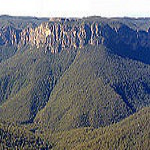

In [27]:
idx = np.random.randint(len(imgs))
print(f"Predicted Label: {classes[net.predict(imgs[idx].unsqueeze(dim=0)).item()]}")
for_disp(imgs[idx])